*<center>[www.joyofdata.de](http://blog.joyofdata.de) - [@joyofdata](https://twitter.com/joyofdata) - [github.com/joyofdata](https://github.com/joyofdata)</center>*

**<center>More information you will find here: [Neural Networks with Caffe on the GPU](http://www.joyofdata.de/blog/neural-networks-with-caffe-on-the-gpu)</center>**

---

<center><h1>Training Multi-Layer Neural Network with Caffe</h1></center>

In [3]:
import subprocess
import platform
import sys

sys.path.append("/Users/manabchetia/Downloads/caffe/python/")
import caffe
caffe.set_mode_gpu()
import lmdb

from sklearn.cross_validation import StratifiedShuffleSplit
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#Status Quo

In [4]:
print "OS:     ", platform.platform()
print "Python: ", sys.version.split("\n")[0]
print "CUDA:   ", subprocess.Popen(["nvcc","--version"], stdout=subprocess.PIPE).communicate()[0].split("\n")[3]
print "LMDB:   ", ".".join([str(i) for i in lmdb.version()])

OS:      Darwin-14.4.0-x86_64-i386-64bit
Python:  2.7.10 |Continuum Analytics, Inc.| (default, May 28 2015, 17:04:42) 
CUDA:    Cuda compilation tools, release 7.0, V7.0.27
LMDB:    0.9.14


#Load Data from CSV and Trasform

The CSV is assumed to be the training data from the ["Otto Group Product Classification Challenge"](https://www.kaggle.com/c/otto-group-product-classification-challenge) at Kaggle. It contains 95 columns:
- [0] id (discarded)
- [1..93] features (integer values)
- [94] label (9 categories - `Class_1,..,Class_9`)

In [5]:
df = pd.read_csv("train.csv", sep=",")
features = df.ix[:,1:-1].as_matrix()
labels = df.ix[:,-1].as_matrix()

IOError: File train.csv does not exist

In [5]:
vec_log = numpy.vectorize(lambda x: log(x+1))
vec_int = numpy.vectorize(lambda str: int(str[-1])-1)

In [6]:
features = vec_log(features)
labels = vec_int(labels)

#Stratified Split for Training and Testing

In [7]:
sss = StratifiedShuffleSplit(labels, 1, test_size=0.02, random_state=0)
sss = list(sss)[0]

In [8]:
features_training = features[sss[0],]
labels_training = labels[sss[0],]

features_testing = features[sss[1],]
labels_testing = labels[sss[1],]

#Load Data into LMDB

In [9]:
# http://deepdish.io/2015/04/28/creating-lmdb-in-python/
def load_data_into_lmdb(lmdb_name, features, labels=None):
    env = lmdb.open(lmdb_name, map_size=features.nbytes*2)
    
    features = features[:,:,None,None]
    for i in range(features.shape[0]):
        datum = caffe.proto.caffe_pb2.Datum()
        
        datum.channels = features.shape[1]
        datum.height = 1
        datum.width = 1
        
        if features.dtype == np.int:
            datum.data = features[i].tostring()
        elif features.dtype == np.float: 
            datum.float_data.extend(features[i].flat)
        else:
            raise Exception("features.dtype unknown.")
        
        if labels is not None:
            datum.label = int(labels[i])
        
        str_id = '{:08}'.format(i)
        with env.begin(write=True) as txn:
            txn.put(str_id, datum.SerializeToString())

In [10]:
load_data_into_lmdb("/home/ubuntu/data/train_data_lmdb", features_training, labels_training)
load_data_into_lmdb("/home/ubuntu/data/test_data_lmdb", features_testing, labels_testing)

#Check Content of LMDB

In [11]:
# http://research.beenfrog.com/code/2015/03/28/read-leveldb-lmdb-for-caffe-with-python.html
def get_data_for_case_from_lmdb(lmdb_name, id):
    lmdb_env = lmdb.open(lmdb_name, readonly=True)
    lmdb_txn = lmdb_env.begin()

    raw_datum = lmdb_txn.get(id)
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)

    feature = caffe.io.datum_to_array(datum)
    label = datum.label

    return (label, feature)

In [12]:
get_data_for_case_from_lmdb("/home/ubuntu/data/train_data_lmdb/", "00012345")

(2, array([[[ 0.        ]],
 
        [[ 0.        ]],
 
        [[ 0.        ]],
 
        [[ 0.        ]],
 
        [[ 0.        ]],
 
        [[ 0.69314718]],
 
        [[ 0.69314718]],
 
        [ ... ],
 
        [[ 0.        ]],
 
        [[ 0.69314718]],
 
        [[ 0.        ]]]))

#Training the Model

In [13]:
proc = subprocess.Popen(
    ["/home/ubuntu/caffe/build/tools/caffe","train","--solver=config.prototxt"], 
    stderr=subprocess.PIPE)
res = proc.communicate()[1]

# http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/hdf5_classification.ipynb
# or
# caffe.set_mode_gpu()
# solver = caffe.get_solver("config.prototxt")
# solver.solve()

In [14]:
print res

libdc1394 error: Failed to initialize libdc1394
I0508 12:19:01.337918  2310 caffe.cpp:113] Use GPU with device ID 0
I0508 12:19:01.502816  2310 caffe.cpp:121] Starting Optimization
I0508 12:19:01.502984  2310 solver.cpp:32] Initializing solver from parameters: 
test_iter: 100
test_interval: 10000
base_lr: 0.01
display: 10000
max_iter: 100000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
solver_mode: GPU
net: "model_train_test.prototxt"
I0508 12:19:01.503021  2310 solver.cpp:70] Creating training net from net file: model_train_test.prototxt
I0508 12:19:01.503921  2310 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer simple
I0508 12:19:01.503988  2310 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0508 12:19:01.504057  2310 net.cpp:42] Initializing net from parameters: 
name: "otto"
state {
  phase: TRAIN
}
layer {
  name: "otto"
  type: "Data"
  top: "data"

#Applying the Model

In [15]:
net = caffe.Net("model_prod.prototxt","./_iter_100001.caffemodel", caffe.TEST)

True 
{'prob': array([[ 0.00519855,  0.83611858,  0.05120391,  0.07174591,  0.0020012 ,
         0.00854634,  0.0165364 ,  0.00283596,  0.00581307]], dtype=float32)}


<Container object of 9 artists>

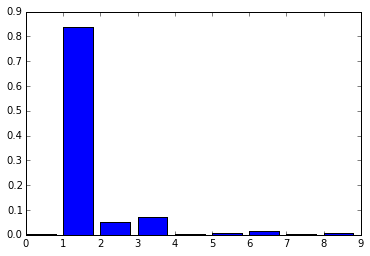

In [16]:
l, f = get_data_for_case_from_lmdb("/home/ubuntu/data/test_data_lmdb/", "00001230")
out = net.forward(**{net.inputs[0]: np.asarray([f])})

# if the index of the largest element matches the integer
# label we stored for that case - then the prediction is right
print np.argmax(out["prob"][0]) == l, "\n", out
plt.bar(range(9),out["prob"][0])

#Visualizing the Network Graph

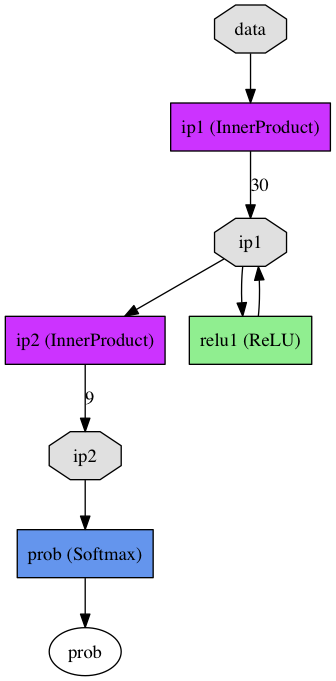

In [6]:
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 

_net = caffe_pb2.NetParameter()
f = open("model_prod.prototxt")
text_format.Merge(f.read(), _net)
display(Image(get_pydot_graph(_net,"TB").create_png()))

#Visualizing the Weights

In [192]:
# weights connecting the input with relu1
arr = net.params["ip1"][0].data

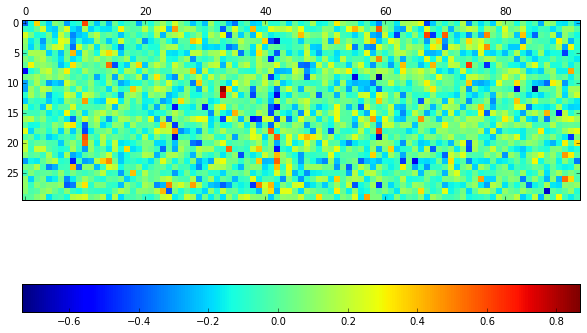

In [222]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fig.colorbar(cax, orientation="horizontal")
cax = ax.matshow(arr, interpolation='none')


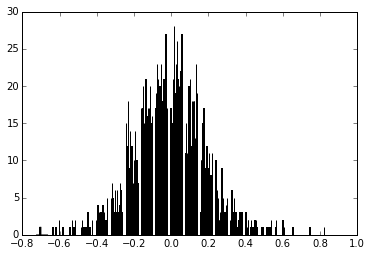

In [230]:
_ = plt.hist(arr.tolist(), bins=20)